# Advanced Lane Detection

## Steps for Project
    1. Calibrate Camera using calibration matrix and distortion coefficients for given chessboard images
    2. Define a Undistortion ultility which undistors any frame of vide using calibration from step #1.
    3. Use perspective transform to get birds eye view of the image.
    4. Create a binary thresold image using sobel, color spaces techiniques taught in lesson.
    5. Find lanes.
    6. Determine curvature of the road.
    7. Unwrap the image back to original shape.
    8. Draw visual display of the lane detected


In [1]:
# Define all imports upfront
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip
import random

# Our utils
from im_utils import read_image, convert_gray
from binary_thresholds import mag_thresh, dir_threshold, r_threshold, s_hls_threshold, l_hls_threshold, \
yellow_threshold, white_threshold

## Step 1: Calibrate camera

### 1.1 Explore Calbiraton images

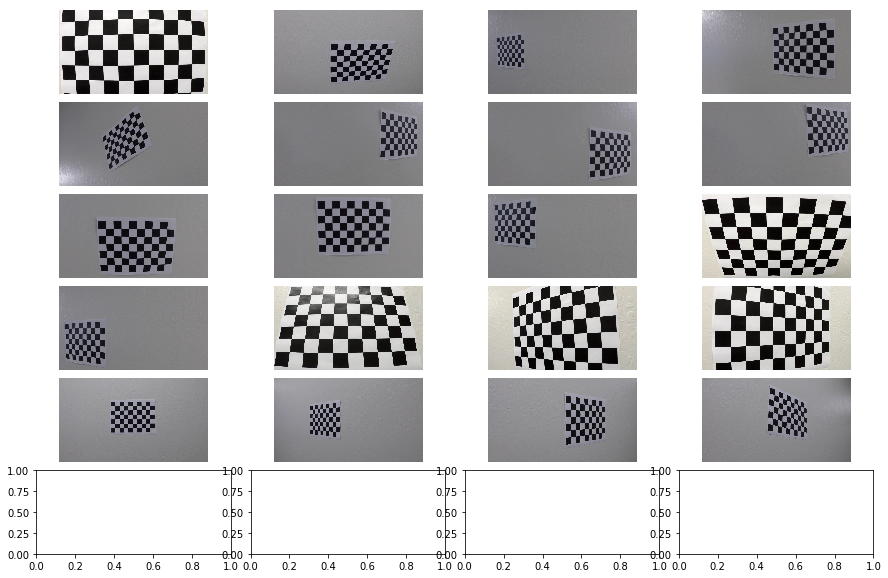

In [2]:
cal_fnames = glob.glob('./camera_cal/calibration*.jpg')

# Explore all images in a 5X4 grid.
def plot_images(images):
    # Plot 4 images per row
    fig, axs = plt.subplots(int(len(images) / 4) + 1, 4, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i, img in enumerate(images):
        axs[i].axis('off')
        axs[i].imshow(img)

        
def explore_calibration_images():
    images = []
    for i, cal_fname in enumerate(cal_fnames):
        img = read_image(cal_fname)
        images.append(img)

    plot_images(images)
    

explore_calibration_images()    
    

### 1.2 Calibrate camera

In [3]:
# Get imagepoints and object points. This is similar to what has been taught in lesson. Except for the fact images provided
# in this project are 9X6

def get_camera_corners(image_paths):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []
    img_with_corners = []
    
    for fname in image_paths:
        img = read_image(fname)
        gr_img = convert_gray(img)
        ret, corners = cv2.findChessboardCorners(gr_img, (9,6), None)
        
        if ret == True:
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            objpoints.append(objp)
            imgpoints.append(corners)
            img_with_corners.append(img)
            
    
    return (img_with_corners, objpoints, imgpoints)

img_with_corners, objpoints, imgpoints = get_camera_corners(cal_fnames)
    

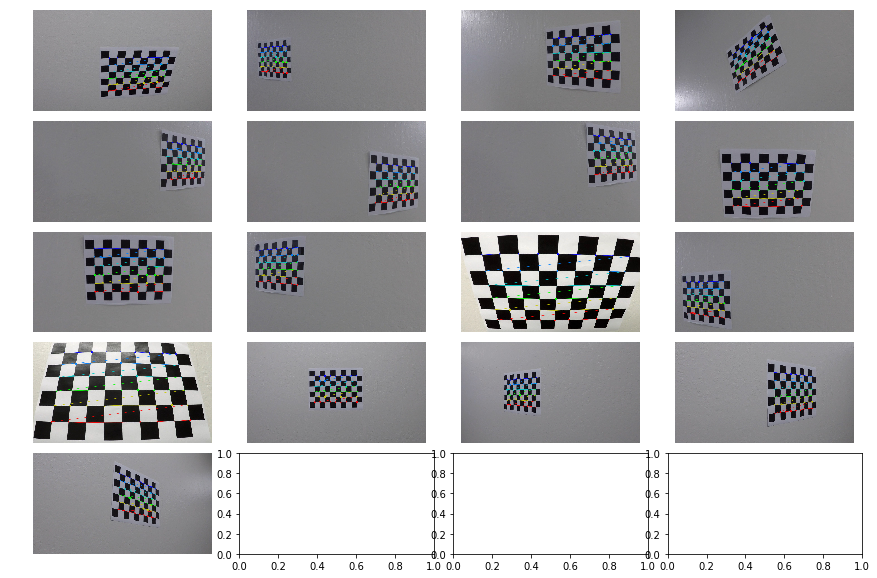

In [4]:
# Explore images after corners have been drawn
plot_images(img_with_corners)

## Step 2: Define a function to undistort images

Text(0.5,1,'UnDistorted Image')

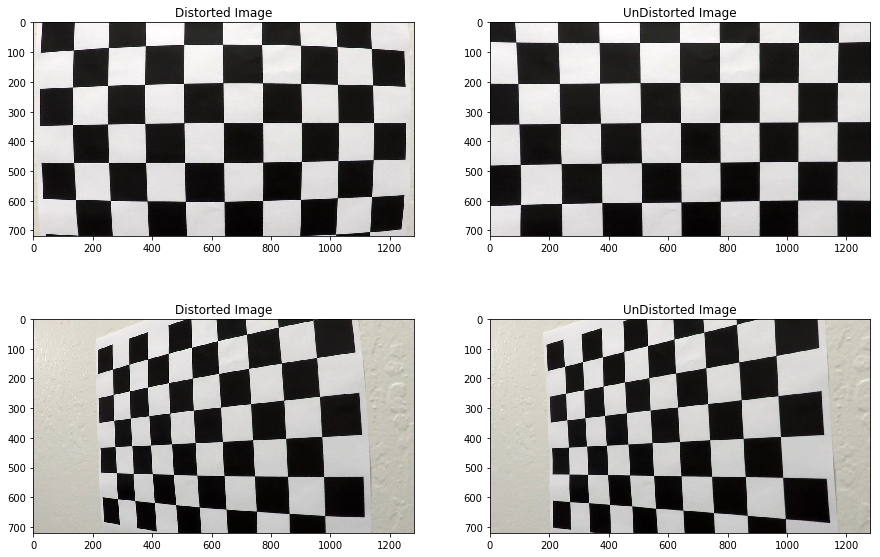

In [5]:
d_img = read_image(cal_fnames[0])
img_size = (d_img.shape[1], d_img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
def undistort_image(dimg):
    undistored = cv2.undistort(dimg, mtx, dist, None, mtx)
    return undistored

# Explore undistortion result
img = read_image('./camera_cal/calibration1.jpg')
dimg = undistort_image(img)

img2 = read_image('./camera_cal/calibration4.jpg')
dimg2 = undistort_image(img2)


f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = axs.ravel()

axs[0].imshow(img)
axs[0].set_title('Distorted Image')
axs[1].imshow(dimg)
axs[1].set_title('UnDistorted Image')

axs[2].imshow(img2)
axs[2].set_title('Distorted Image')
axs[3].imshow(dimg2)
axs[3].set_title('UnDistorted Image')

## Step 3: Warp and unwarp images

### 3.1 Explore test images

Shape of Test images (720, 1280, 3)


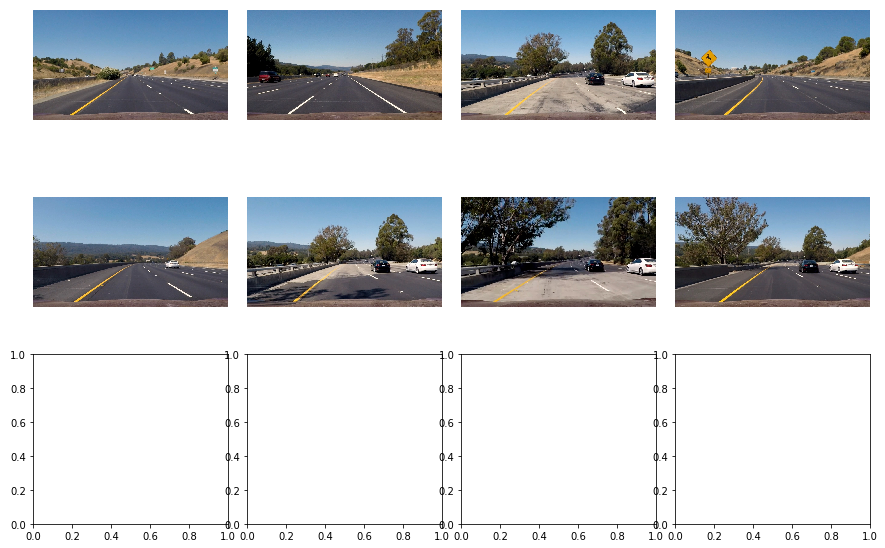

In [6]:
test_fnames = glob.glob('./test_images/*.jpg')

print("Shape of Test images", read_image(test_fnames[0]).shape)
def explore_test_images():
    images = []
    for i, test_fname in enumerate(test_fnames):
        img = read_image(test_fname)
        images.append(img)
    plot_images(images)
    

explore_test_images()    



### 3.2 Define Perspective Transform function

In [7]:
def warp_image(image, mapper):
    return cv2.warpPerspective(image, mapper, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

def do_perspective_transform(image, src, dst):
    """
        returns warped_image, m_inv (which can be used later to invert the image)
    """
    m = cv2.getPerspectiveTransform(src, dst)
    m_inv = cv2.getPerspectiveTransform(dst, src)
    warped_image = warp_image(image, m)
    return warped_image, m_inv

### 3.3 Explore various warp points

In [8]:
def visualize_warp(images, src, dst):
    f, axs = plt.subplots(len(images), 4, figsize=(15,10))
    f.subplots_adjust(hspace = .5, wspace=.1)
    axs = axs.ravel()
    i = 0
    for img in images:
        undis_image = undistort_image(img)
        warped_image, m_inv = do_perspective_transform(undis_image, src, dst)
        unwarped_image = warp_image(warped_image, m_inv)

        axs[i].imshow(img)
        axs[i].set_title('Original image')
        i += 1
        
        axs[i].imshow(undis_image)
        axs[i].set_title('Undistorted image')
        i += 1
        
        axs[i].imshow(warped_image)
        axs[i].set_title('Warped Image')
        i += 1
        
        axs[i].imshow(unwarped_image)
        axs[i].set_title('UnWarped Image')
        i += 1
        

In [10]:
testimgs = []
for test_fname in test_fnames[0:3]:
    testimgs.append(read_image(test_fname))
    
def test1_src_dest():
    height, width, _ = img.shape

    src = np.float32([(520.,410.),
                      (685.,410.), 
                      (225.,660.),
                      (1130.,660.) 
                      ])

    dst = np.float32([(400.,0),
                      (width-400.,0),
                      (400.,height),
                      (width-400.,height)])

    visualize_warp(testimgs, src, dst)
    return src, dst
        
def test2_src_dest():
    img = read_image(test_fnames[2])
    height, width, _ = img.shape

    src = np.float32([(570.,450.),
                      (705.,450.), 
                      (255.,670.),
                      (1110.,670.) 
                      ])

    dst = np.float32([(445.,0),
                      (width-445.,0),
                      (445.,height),
                      (width-445.,height)])

    visualize_warp(testimgs, src, dst)
    return src, dst

def test3_src_dest():
    img = read_image(test_fnames[2])
    height, width, _ = img.shape

    src = np.float32([(580.,460.),
                      (720.,460.), 
                      (255.,680.),
                      (1090.,680.) 
                      ])

    dst = np.float32([(445.,0),
                      (width-445.,0),
                      (445.,height),
                      (width-445.,height)])

    visualize_warp(testimgs, src, dst)    
    return src, dst

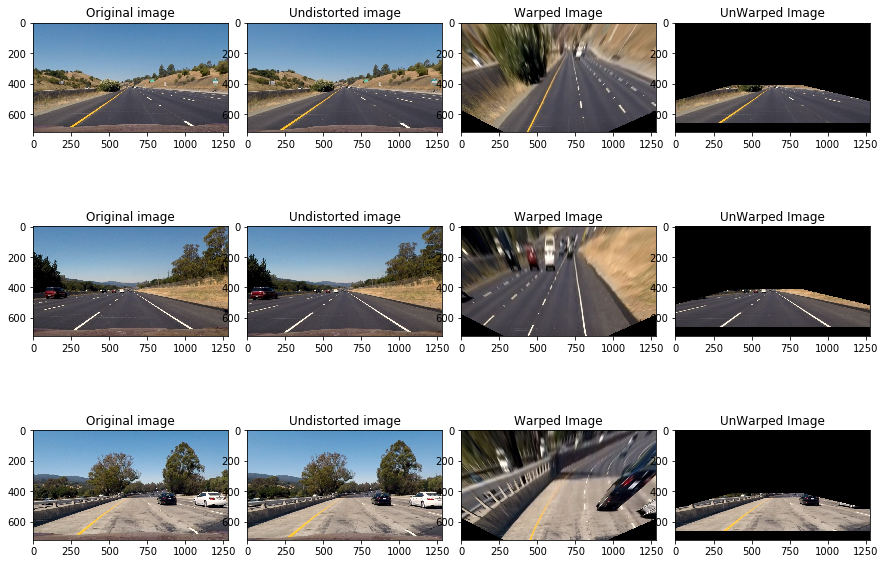

In [11]:
src1, dst1 = test1_src_dest()

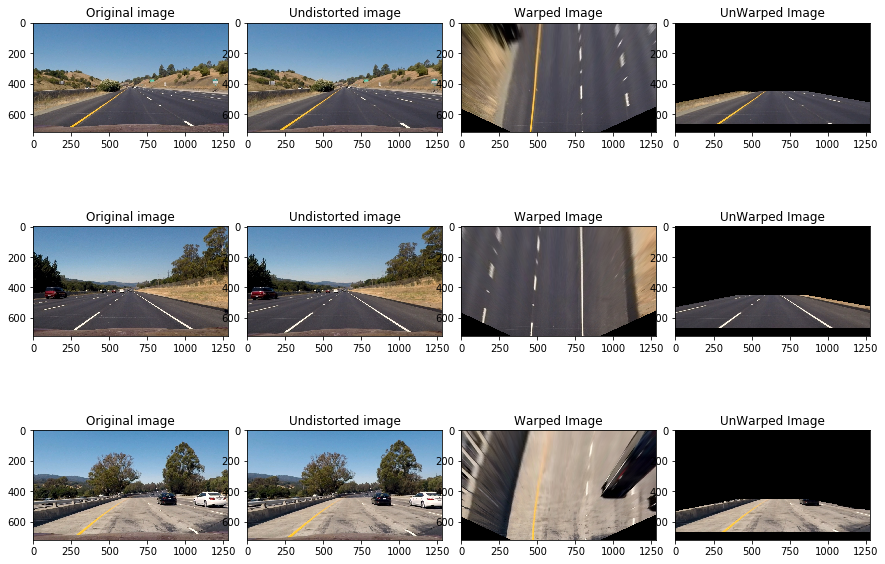

In [12]:
src2, dst2 = test2_src_dest()

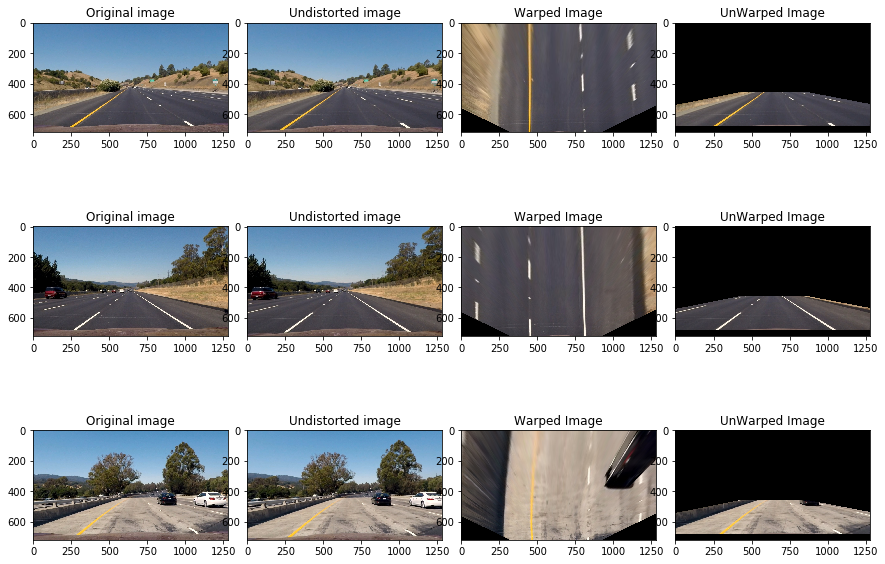

In [13]:
src3, dst3 = test3_src_dest()

### 3.4 Final warp points

In [14]:
final_src, final_dst = src3, dst3

## Step 4: Binary Thresholds for the Image

### 4.1: Create a util method to display output of threshold on 5 random images from project video

In [15]:
def get_video_images():
    video_file = './project_video.mp4'
    images=[]
    count=0
    
    def convert_frame(img):
        nonlocal count
        return img
    
    clip = VideoFileClip(video_file)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]  
    return images

proj_video_images = get_video_images()
print(len(proj_video_images))


100%|█████████▉| 1260/1261 [00:04<00:00, 289.65it/s]

1260


In [45]:
rand_image_indices = random.sample(range(len(proj_video_images)), 5)
random_proj_images = [proj_video_images[i] for i in rand_image_indices]
    
def visualize_thresholds(thresold_func):
    f, axs = plt.subplots(len(random_proj_images), 2, figsize=(20,15))
    f.subplots_adjust(hspace = .5, wspace=.01)
    axs = axs.ravel()
    i = 0
    for img in random_proj_images:
        undis_img = undistort_image(img)
        warped_image, _ = do_perspective_transform(undis_img, final_src, final_dst)
        thresold_image = thresold_func(warped_image)
        axs[i].imshow(warped_image, cmap='gray')
        axs[i].set_title('Warped image')
        i += 1     
        axs[i].imshow(thresold_image, cmap='gray')
        axs[i].set_title('Threshold image')
        i += 1



================== FINAL MAG THRESHOLD OUTPUTS ==================


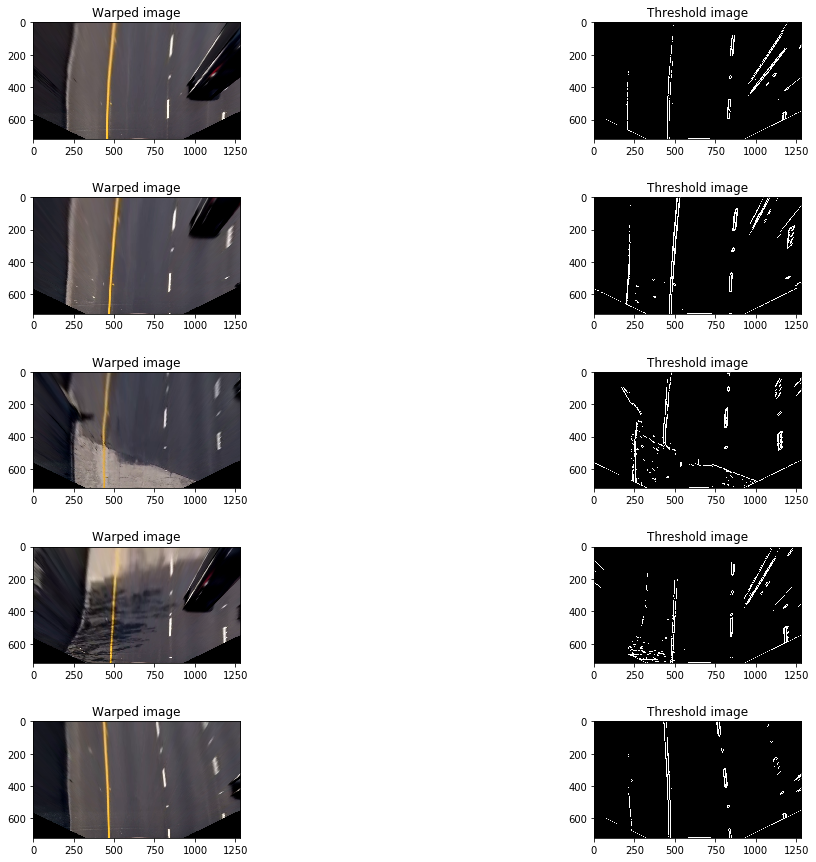

In [46]:
def magnitude_threshold(img_rgb):
    # return mag_thresh(img_rgb, sobel_kernel=3, thresh_min=0, thresh_max=255)
    # return mag_thresh(img_rgb, sobel_kernel=3, thresh_min=25, thresh_max=225)
    # return mag_thresh(img_rgb, sobel_kernel=3, thresh_min=35, thresh_max=215)
    return mag_thresh(img_rgb, sobel_kernel=9, thresh_min=35, thresh_max=235)
    # return mag_thresh(img_rgb, sobel_kernel=3, thresh_min=40, thresh_max=200)
    # return mag_thresh(img_rgb, sobel_kernel=3, thresh_min=65, thresh_max=105)
print()
print("================== FINAL MAG THRESHOLD OUTPUTS ==================")    
visualize_thresholds(magnitude_threshold)


================== FINAL DIRECTION THRESHOLD OUTPUTS ==================


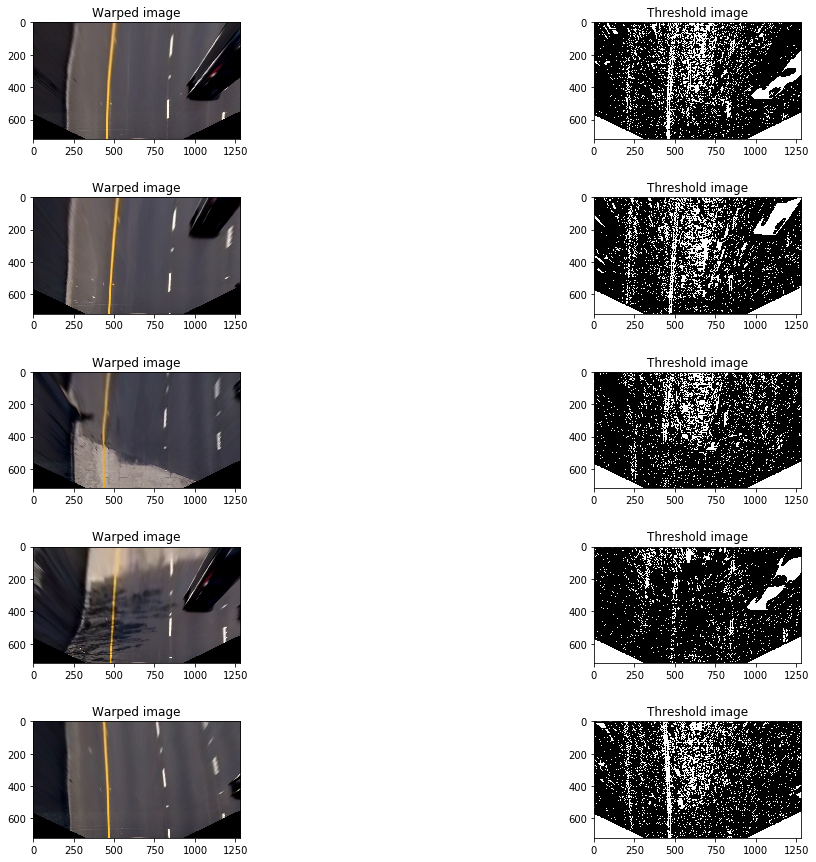

In [47]:
def direction_threshold(img_rgb):
    # return dir_threshold(img_rgb, sobel_kernel=15, thresh_min=0, thresh_max=0.02)
    # return dir_threshold(img_rgb, sobel_kernel=15, thresh_min=0, thresh_max=0.3)
    return dir_threshold(img_rgb, sobel_kernel=11, thresh_min=0, thresh_max=0.12)

print()
print("================== FINAL DIRECTION THRESHOLD OUTPUTS ==================")       
visualize_thresholds(direction_threshold)   


================== FINAL L + S + Grad THRESHOLD OUTPUTS ==================


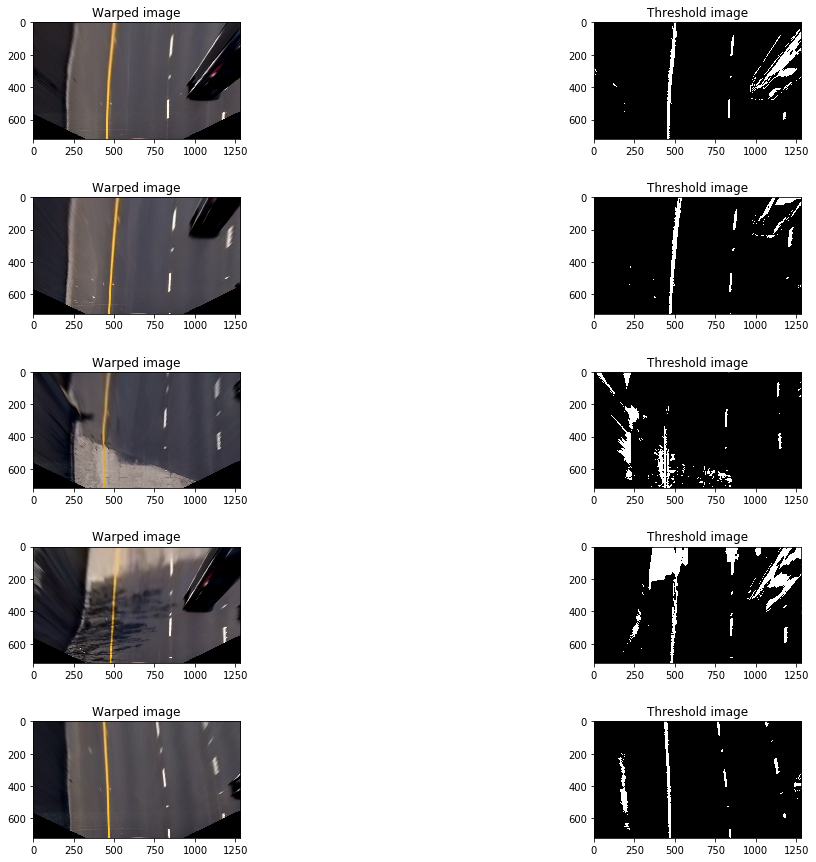

In [56]:
def l_s_grad_threshold(img_rgb):
    l_out = l_hls_threshold(img_rgb, thresh_min=190, thresh_max=255)
    s_out = s_hls_threshold(img_rgb, thresh_min=100, thresh_max=255)
    mag_out = magnitude_threshold(img_rgb)
    grad_out = direction_threshold(img_rgb)
    binary_out = np.zeros_like(l_out)
    binary_out[(l_out == 1)  | (s_out == 1) | (grad_out==1) | (mag_out == 1) ] = 1
    return binary_out

print()
print("================== FINAL L + S + Grad THRESHOLD OUTPUTS ==================")       
visualize_thresholds(r_s_threshold)   


================== FINAL Yellow + White THRESHOLD OUTPUTS ==================


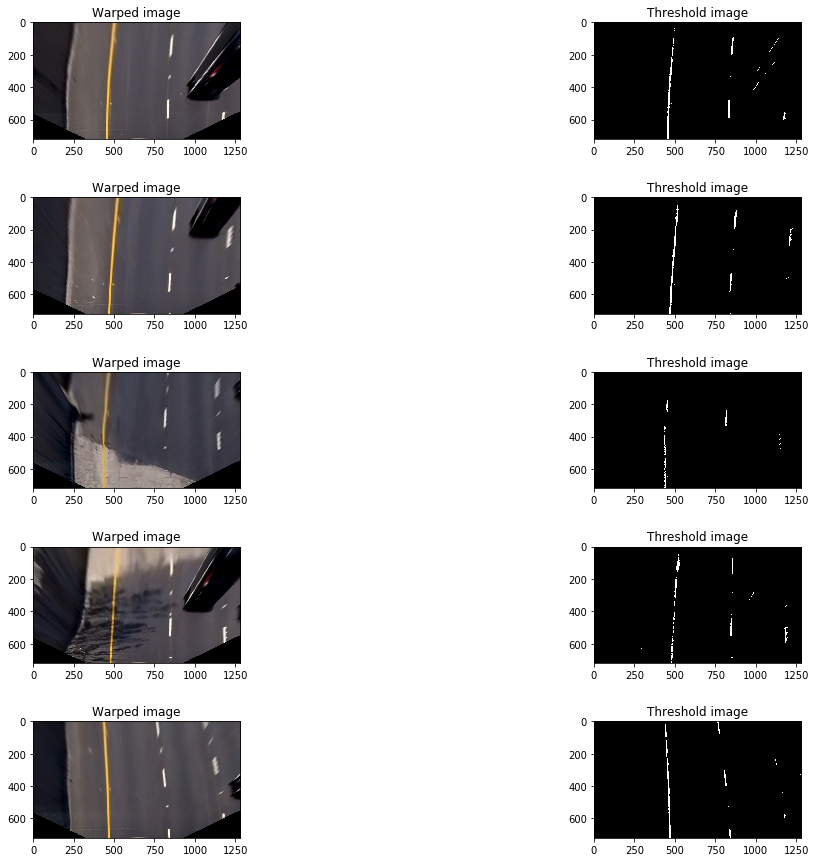

In [57]:
def y_w_grad_threshold(img_rgb):
    # Captures of yellow or white
    y_out = yellow_threshold(img_rgb)
    w_out = white_threshold(img_rgb)
    binary_out = np.zeros_like(y_out)
    binary_out[(y_out == 1)  | (w_out == 1)] = 1
    return binary_out

print()
print("================== FINAL Yellow + White THRESHOLD OUTPUTS ==================")       
visualize_thresholds(y_w_grad_threshold)   


================== FINAL COMBINED THRESHOLD OUTPUTS ==================


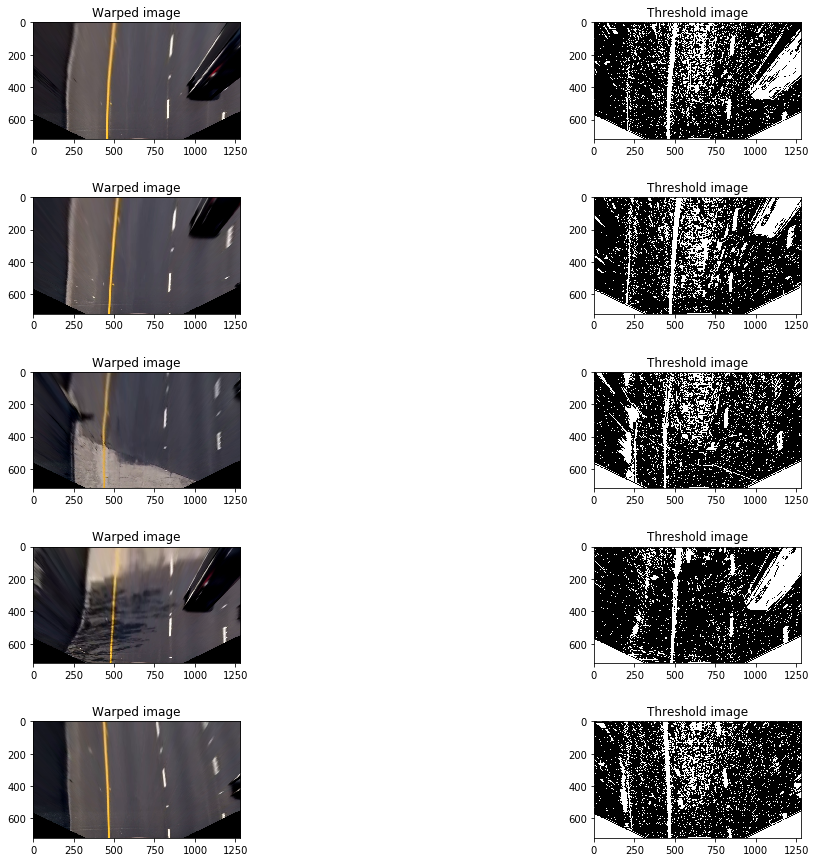

In [59]:
def combined_threshold(img_rgb):
    # Combination of (yellow or white) & (l_s_grad_threshold)
    y_w_out = y_w_grad_threshold(img_rgb)
    l_s_grad_out = l_s_grad_threshold(img_rgb)
    binary_out = np.zeros_like(y_w_out)
    binary_out[(y_w_out == 1)  & (l_s_grad_out == 1)] = 1
    return binary_out

print()
print("================== FINAL COMBINED THRESHOLD OUTPUTS ==================")       
visualize_thresholds(combined_threshold)  